# Satellite imagery access and analysis in Python & Jupyter notebooks


## Access, preprocess, analyse and visualize satellite images in Jupyter notebooks with Python.

The vast amount of satellite imagery collected every day across the globe is huge. In this tutorial, we will learn how to access satellite images, analyze and visualize them right in Jupyter notebooks with python. Satellite images are pixel wised data just like any other types of images you have used. In Geography and Remote sensing terminology, this is called Rasters. Raster images mainly consist of satellite images, Lidar data as well as Georeferenced maps. As we will see, rasters consist of a matrix of cells and row and each cell holds information about the location, such as elevation, temperature and vegetation.


In this tutorial, we will cover the following:
* Querry, retrieve and download satellite images directly with Python in Jupyter notebook.
* Read and Write Raster images in Python.
* Create RGB and NDVI images from Sentinel 2 Bands

### Accessing data
In this tutorial, we will use Sentinel 2 data. There are many options to access Sentinel 2 images and most of them will require you to access through website interaction whether directly via a downloading service utility or via the cloud. However, since we are using Jupyter notebook, we will access them right here using, sentinelsat a python library which makes searching, retrieving and downloading Sentinel satellite images easy. So let us start installing sentinelsat through pip.

In [10]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

Before we are able to use sentinelsat, we need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

In [11]:
user = 'user' 
password = 'password' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

You are all set to use sentinelsat and download Sentinel Satellite images. In this tutorial, we will use data from Roma city, Italy. In the southern part of Roma, there is a natural reserve called Castel Porziano which we will use as a boundary to clip from the whole satellite image tile. 
I have the boundary of the natural reserve as Shapefile and we will read it with Geopandas and visualize it with Folium python library.

In [17]:
SF_buildings = gpd.read_file('./SanFrancisco-shp/shape/buildings.shp')
SF_buildings

osm_id  name          type  \
0          8915166  None          None   
1         23652511  None          None   
2         23652518  None          None   
3         23652522  None          None   
4         23652526  None          None   
...            ...   ...           ...   
287010  1000327256  None          None   
287011  1000327257  None          None   
287012  1000832626  None          None   
287013  1001544694  None  construction   
287014  1001544698  None          None   

                                                 geometry  
0       POLYGON ((-122.43349 37.79001, -122.43345 37.7...  
1       POLYGON ((-122.34144 37.59000, -122.34103 37.5...  
2       POLYGON ((-122.34916 37.59104, -122.34940 37.5...  
3       POLYGON ((-122.35737 37.59113, -122.35655 37.5...  
4       POLYGON ((-122.33958 37.58878, -122.33897 37.5...  
...                                                   ...  
287010  POLYGON ((-122.49783 37.54886, -122.49780 37.5...  
287011  POLYGON ((-122.50360 37.55021, -122.50359 37.5...  
287012  POLYGON ((-122.36378 37.81047, -122.36378 37.8...  
287013  POLYGON ((-122.37308 37.82106, -122.37262 37.8...  
287014  POLYGON ((-122.37561 37.82200, -122.37556 37.8...  

[287015 rows x 4 columns]

In [ ]:
m = folium.Map([37.7749, -122.4194], zoom_start=10,  prefer_canvas=True)

folium.GeoJson(SF_buildings).add_to(m)
m

With the above code, we have read natural reserve shapefile in Geopandas and called it nReserve, then later created an empty base map in Folium centred around coordinates in the area, we call this m. Finally, we can add the Geopandas data to the base map we have created to visualize the Natural Reserve boundary we are interested in. Below you can see the map.

One last step before we can search and download sentinel 2 images is to create a footprint from the nReservegeometry. Here we will use Shapely Python library since our data is in Shapefiles and read it already as Geopandas GeodataFrame. (Note that if you have Geojson data, Sentinelsat provides a handy way to convert your data into a proper format in the query).

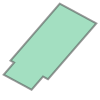

In [18]:
footprint = None
for i in SF_buildings['geometry']:
    footprint = i
    
footprint

Now we can run a query on the apiwe have created above. There are different ways you can construct your query here depending on your use case. In this example, we will create a query for Sentinel 2 images Level 2A with cloud coverage between 0 and 10 that fall or intersect with the footprint (Area of study). For the time period, we are interested in Sentinel Level 2A satellite images taken between '20190601' and '20190626' (For reference on valid search queries please refer to[ scihub](https://scihub.copernicus.eu/twiki/do/view/SciHubUserGuide/FullTextSearch?redirectedfrom=SciHubUserGuide.3FullTextSearch)).

In [25]:
products = api.query(footprint,
                     date = ('20211001', '20211127'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10))

We get a dictionary of all products available in this period with the query specification. In this case, we receive only 6 images taken but you can tweak the query for your use case example expanding the time period or increasing the cloud coverage percentage.  


In [26]:
len(products)

5

From here we can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage.

In [27]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

C:\Users\Blob2\.conda\envs\gis_rs\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


title  \
7850eea1-68e9-48e2-a8ec-4736dfe688bd  S2A_MSIL2A_20211016T185401_N0301_R113_T10SEG_2...   
47c00ff2-5b76-4e84-a513-3c73847f0af1  S2B_MSIL2A_20211011T185319_N0301_R113_T10SEG_2...   
ca62176e-6062-400e-93ec-b1cd59721c5e  S2B_MSIL2A_20211001T185119_N0301_R113_T10SEG_2...   
db013295-d581-41b4-8d6f-06d0351308db  S2B_MSIL2A_20211120T185659_N0301_R113_T10SEG_2...   
1c7411d4-9c60-424a-a983-6e86c84c1c5b  S2B_MSIL2A_20211001T185119_N0301_R113_T10SEG_2...   

                                                                                   link  \
7850eea1-68e9-48e2-a8ec-4736dfe688bd  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
47c00ff2-5b76-4e84-a513-3c73847f0af1  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ca62176e-6062-400e-93ec-b1cd59721c5e  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
db013295-d581-41b4-8d6f-06d0351308db  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
1c7411d4-9c60-424a-a983-6e86c84c1c5b  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
7850eea1-68e9-48e2-a8ec-4736dfe688bd  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
47c00ff2-5b76-4e84-a513-3c73847f0af1  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ca62176e-6062-400e-93ec-b1cd59721c5e  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
db013295-d581-41b4-8d6f-06d0351308db  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
1c7411d4-9c60-424a-a983-6e86c84c1c5b  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
7850eea1-68e9-48e2-a8ec-4736dfe688bd  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
47c00ff2-5b76-4e84-a513-3c73847f0af1  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ca62176e-6062-400e-93ec-b1cd59721c5e  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
db013295-d581-41b4-8d6f-06d0351308db  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
1c7411d4-9c60-424a-a983-6e86c84c1c5b  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
7850eea1-68e9-48e2-a8ec-4736dfe688bd  Date: 2021-10-16T18:54:01.024Z, Instrument: MS...   
47c00ff2-5b76-4e84-a513-3c73847f0af1  Date: 2021-10-11T18:53:19.024Z, Instrument: MS...   
ca62176e-6062-400e-93ec-b1cd59721c5e  Date: 2021-10-01T18:51:19.024Z, Instrument: MS...   
db013295-d581-41b4-8d6f-06d0351308db  Date: 2021-11-20T18:56:59.024Z, Instrument: MS...   
1c7411d4-9c60-424a-a983-6e86c84c1c5b  Date: 2021-10-01T18:51:19.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
7850eea1-68e9-48e2-a8ec-4736dfe688bd    false 2021-10-16 21:38:39   
47c00ff2-5b76-4e84-a513-3c73847f0af1    false 2021-10-11 21:50:18   
ca62176e-6062-400e-93ec-b1cd59721c5e    false 2021-10-01 21:57:30   
db013295-d581-41b4-8d6f-06d0351308db    false 2021-11-20 21:02:04   
1c7411d4-9c60-424a-a983-6e86c84c1c5b    false 2021-10-01 22:47:00   

                                               beginposition  \
7850eea1-68e9-48e2-a8ec-4736dfe688bd 2021-10-16 18:54:01.024   
47c00ff2-5b76-4e84-a513-3c73847f0af1 2021-10-11 18:53:19.024   
ca62176e-6062-400e-93ec-b1cd59721c5e 2021-10-01 18:51:19.024   
db013295-d581-41b4-8d6f-06d0351308db 2021-11-20 18:56:59.024   
1c7411d4-9c60-424a-a983-6e86c84c1c5b 2021-10-01 18:51:19.024   

                                                 endposition  \
7850eea1-68e9-48e2-a8ec-4736dfe688bd 2021-10-16 18:54:01.024   
47c00ff2-5b76-4e84-a513-3c73847f0af1 2021-10-11 18:53:19.024   
ca62176e-6062-400e-93ec-b1cd59721c5e 2021-10-01 18:51:19.024   
db013295-d581-41b4-8d6f-06d0351308db 2021-11-20 18:56:59.024   
1c7411d4-9c60-424a-a983-6e86c84c1c5b 2021-10-01 18:51:19.024   

                                               ingestiondate  ...  \
7850eea1-68e9-48e2-a8ec-4736dfe688bd 2021-10-17 00:31:48.116  ...   
47c00ff2-5b76-4e84-a513-

Let us say we are interested in the first satellite image since this has the least cloud coverage of all available images. we can simply call download and provide the product name (Note that you can download all images at once with api.download_all() function).

In [28]:
api.download("7850eea1-68e9-48e2-a8ec-4736dfe688bd")

MD5 checksumming:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

{'id': '7850eea1-68e9-48e2-a8ec-4736dfe688bd',
 'title': 'S2A_MSIL2A_20211016T185401_N0301_R113_T10SEG_20211016T213839',
 'size': 1006305218,
 'md5': '52090eca7b0e63c345b4e690b424153f',
 'date': datetime.datetime(2021, 10, 16, 18, 54, 1, 24000),
 'footprint': 'POLYGON((-123.00023 37.947589571993284,-121.75064 37.94095623057468,-121.767 36.95147947183065,-123.00023 36.95788109520145,-123.00023 37.947589571993284))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('7850eea1-68e9-48e2-a8ec-4736dfe688bd')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2021, 10, 17, 0, 32, 9, 669000),
 'Ingestion Date': datetime.datetime(2021, 10, 17, 0, 31, 48, 116000),
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('7850eea1-68e9-48e2-a8ec-4736dfe688bd')/Products('Quicklook')/$value",
 'path': 'S2A_MSIL2A_20211016T185401_N0301_R113_T10SEG_20211016T213839.zip',
 'downloaded_bytes': 1006305218}

This will take a while (Sentinel 2 Satellite image tiles are about 1 GB). Once the download is finished, we can simply unzip it. In the next section, we will use the downloaded satellite images to process, analyze and visualize them.

## Exploring Satellite Imagery with Rasterio
Once we unzip the downloaded folder, we get many subfolders and it is sometimes hard to navigate through these folders. Sentinel-2 data is multispectral with 13 bands in the visible, near infrared and shortwave infrared spectrum. These bands come in a different spatial resolution ranging from 10 m to 60 m, thus images can be categorized as high-medium resolution. While there are other higher resolution satellites available(1m to 0.5 cm), Sentinel-2 data is free and has a high revisit time (5 days) which makes it an excellent option to study environmental challenges.

### Create RGB Image 
The true colour of satellite images is often displayed in a combination of red, green and blue band. Let us first read the data with Rasterio and create an RGB image from Bands 4, 3, and 2.

In [30]:
# Open Bands 4, 3 and 2 with Rasterio
R10 = 'S2A_MSIL2A_20211016T185401_N0301_R113_T10SEG_20211016T213839.SAFE/GRANULE/L2A_T10SEG_A033000_20211016T190203/IMG_DATA/R10m'

b4 = rio.open(R10+'/T10SEG_20211016T185401_B04_10m.jp2')
b3 = rio.open(R10+'/T10SEG_20211016T185401_B03_10m.jp2')
b2 = rio.open(R10+'/T10SEG_20211016T185401_B02_10m.jp2')

In [31]:
b4.count, b4.width, b4.height

(1, 10980, 10980)

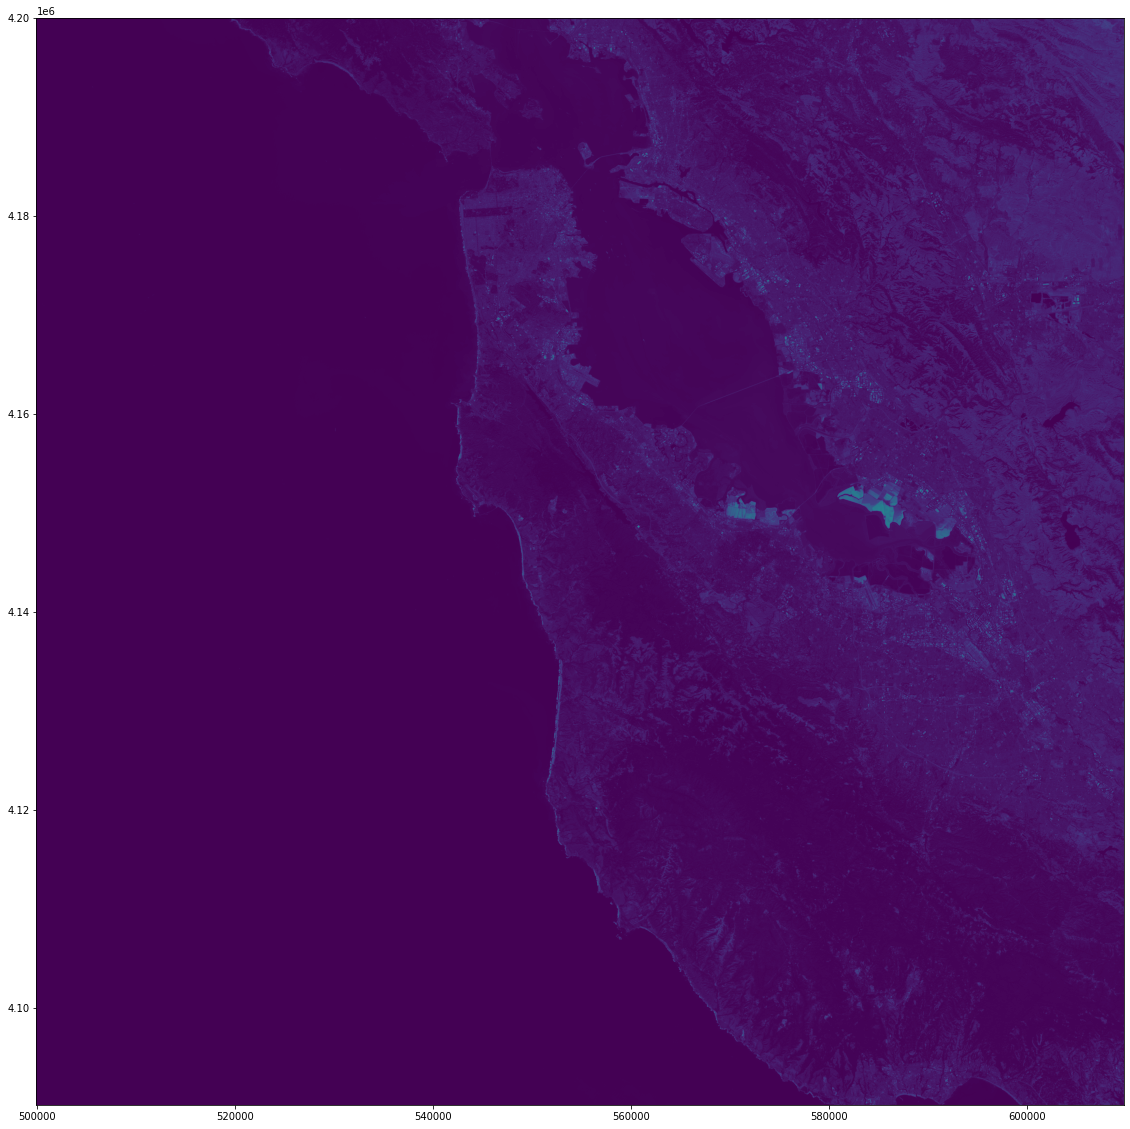

In [32]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(b4, ax=ax)
plt.show()

In [33]:
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

### Mask Satellite images

One important preprocessing task to clip or mask an area of study. Since this RGB image is large and huge you save both computing power and time to clip and use only the area of interest. We will clip the Natural reserve area from the RGB image.

In [36]:
#src = rio.open(r"RGB.tiff")
SF_buildings_proj = SF_buildings.to_crs({'init': 'epsg:32633'})

with rio.open("RGB.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, SF_buildings_proj.geometry, invert=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

C:\Users\Blob2\.conda\envs\gis_rs\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Blob2\.conda\envs\gis_rs\lib\site-packages\rasterio\mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


Here, we first reproject our Natural reserve with the same projection as the RGB image. Next, we open the RGB image, get the metadata and mask with the projected boundary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


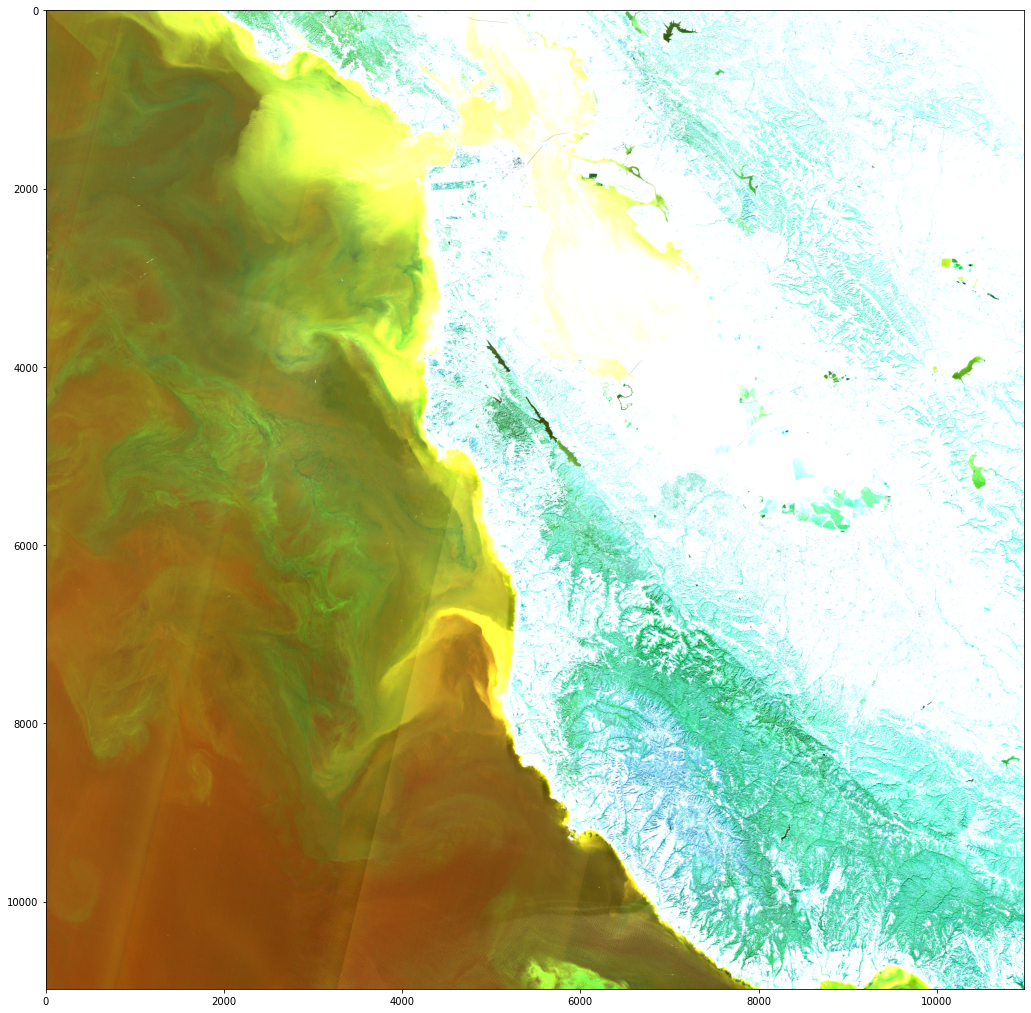

<function matplotlib.pyplot.show(close=None, block=None)>

In [37]:
msk = rio.open(r"RGB_masked.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show

### Create NDVI 
Calculating Normalized Difference Vegetation Index (NDVI) is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the NDVI, you need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for this band. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:
nir - red /(nir + red).

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

In [38]:
b4 = rio.open(R10+'/T10SEG_20211016T185401_B04_10m.jp2')
b8 = rio.open(R10+'/T10SEG_20211016T185401_B08_10m.jp2')

In [39]:
red = b4.read()
nir = b8.read()

In [40]:
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

In [41]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

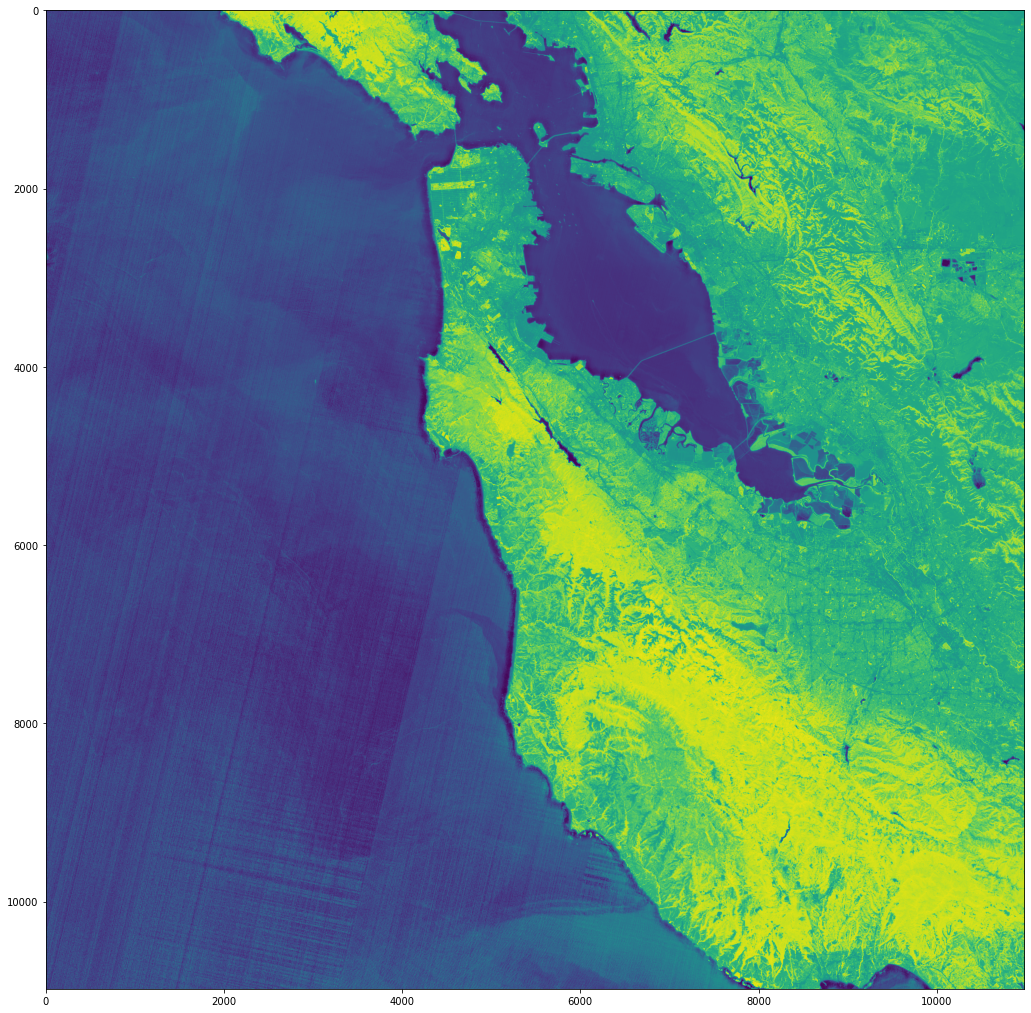

<function matplotlib.pyplot.show(close=None, block=None)>

In [45]:
msk = rio.open(r"NDVI.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1]))
plt.show

# Conclusion
Accessing Sentinel 2 images with Python is made easy with sentinelsat. In this tutorial, we have covered how to construct a query and retrieve on information from available images as well as how to download Sentinel 2 images within Jupyter notebooks. We have also seen how to preprocess, create RGB and NDVI images and visualize raster images with Rasterio.